<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#A4-Neural-Network-Classifier" data-toc-modified-id="A4-Neural-Network-Classifier-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>A4 Neural Network Classifier</a></span><ul class="toc-item"><li><span><a href="#NeuralNetworkClassifier" data-toc-modified-id="NeuralNetworkClassifier-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span><code>NeuralNetworkClassifier</code></a></span></li><li><span><a href="#percent_correct" data-toc-modified-id="percent_correct-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span><code>percent_correct</code></a></span></li><li><span><a href="#Apply-NeuralNetworkClassifier-to-Images-of-Handwritten-Digits" data-toc-modified-id="Apply-NeuralNetworkClassifier-to-Images-of-Handwritten-Digits-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Apply <code>NeuralNetworkClassifier</code> to Images of Handwritten Digits</a></span></li><li><span><a href="#Define-train_for_best_validation-and-apply-to-MNIST-data" data-toc-modified-id="Define-train_for_best_validation-and-apply-to-MNIST-data-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Define <code>train_for_best_validation</code> and apply to MNIST data</a></span></li></ul></li><li><span><a href="#Grading" data-toc-modified-id="Grading-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Grading</a></span></li><li><span><a href="#Extra-Credit" data-toc-modified-id="Extra-Credit-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Extra Credit</a></span></li></ul></div>

**Abhishek Balasubramaniam**


# A4 Neural Network Classifier

## `NeuralNetworkClassifier`

Starting with the `NeuralNetwork` class defined in Lecture Notes 12, complete the subclass `NeuralNetworkClassifier` as discussed.

## `percent_correct`

When trying to classify real data, we need a way to evaluate our performance.  One way is to just calculate the percent of samples correctly classified, and to show a confusion matrix.  Define the function
`percent_correct(Y, T)`, that returns the percent of samples correctly classified, given `T` as a column matrix of class labels, and `Y` as the column matrix of classes predicted by `use`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import optimizers as opt
import pandas as pd
import sys
sys.float_info.epsilon

2.220446049250313e-16

In [2]:
class NeuralNetwork():

    
    def __init__(self,n_inputs,n_hiddens_list,n_outputs):
        self.n_inputs =n_inputs
        self.n_hiddens_list = n_hiddens_list
        self.n_outputs = n_outputs
        self.n_layers = len(self.n_hiddens_list)+1
        self.all_weights, self.Ws = self.make_weights()
        self.initialize_weights()
        self.all_gradients, self.Gs = self.make_weights()

        self.stand_params =None
        self.error_trace = []
            
    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, {self.n_hiddens_list}, {self.n_outputs})'
    
    def add_ones(self,Xst):
        return np.insert(Xst,0,1,axis=1)  
    
#....................make_weights.............................  
    def make_weights(self):
        # Create list of matrix shapes, one per layer
        n_in = self.n_inputs
        units = self.n_hiddens_list + [self.n_outputs]
        shapes = []
        for n_units in units:
            shapes.append((n_in + 1, n_units))
            n_in = n_units

        # Allocate contiguous memory to hold all weights
        n_weights = sum([ni * nu for (ni, nu) in shapes])
        all_weights = np.zeros(n_weights)

        # Create numpy views into this memory with the appropriate
        # shapes to be our weight matrices.
        Ws = []
        first = 0
        for (ni, nu) in shapes:
            n_w = ni * nu
            W = all_weights[first:first + n_w].reshape(ni, nu)
            Ws.append(W)
            first += n_w

        return all_weights, Ws
    
 #....................intialize_weights............................. 
    def initialize_weights(self):
        for W in self.Ws:
            ni, nu = W.shape
            W[:] = np.random.uniform(-1, 1, size=(ni, nu)) / np.sqrt(ni)
        self.error_trace = []
    
    
    def calc_standardize_parameters(self,X,T):
        Xmeans=X.mean(axis=0)
        Xstds=X.std(axis=0)
        Xstds[Xstds == 0] = np.mean(Xstds[Xstds > 0])
        Tmeans=T.mean(axis=0)
        Tstds=T.std(axis=0)
        
         
        return {'Xmeans': Xmeans, 'Xstds': Xstds,
                           'Tmeans': Tmeans, 'Tstds':Tstds}

    def standardize_X(self,X):
#         print(self.stand_params['Xmeans'])
        return (X - self.stand_params['Xmeans']) / self.stand_params['Xstds']


    def unstandardize_X(self,Xst):
        return Xst * self.stand_params['Xstds'] + self.stand_params['Xmeans']


    def standardize_T(self,T):
        return (T - self.stand_params['Tmeans']) / self.stand_params['Tstds']


    def unstandardize_T(self,Tst):
        return Tst * self.stand_params['Tstds'] + self.stand_params['Tmeans']

    def forward(self,Xst):
        print("old")
        Ys = [Xst]
        for layer_i, W in enumerate(self.Ws):
            X = Ys[-1]
            Y = self.add_ones(X) @ W
            if layer_i < self.n_layers - 1:
                Y = np.tanh(Y)
            Ys.append(Y)
        return Ys[1:]  # remove X from Ys

    # Change arguments to replace V, W with Ws
    def backward(self,Xst, Tst):
        n_samples = Xst.shape[0]
        n_outputs = Tst.shape[1]

        output = self.forward(Xst)
        
        output[:0] = [Xst]
        
       
        delta = - (Tst - output[-1]) /  (n_samples * n_outputs)

        for layer in range(len(self.Ws) - 1, -1, -1):
#          
            self.Gs[layer][:]=(self.add_ones(output[layer]).T @ delta)
           
            delta = (delta @ self.Ws[layer][1:, :].T) * (1 - output[layer] ** 2)

       
        return self.all_gradients


    def mse(self,Xst, Tst):
        Yst = self.forward(Xst)
        return 0.5*np.mean((Tst - Yst[-1])**2)  # can multipy a 0.5

    def train(self,X, T, learning_rate, n_epochs, method,verbose=False):
                
        print("old")

   

        self.calc_standardize_parameters(X, T)


        def error_convert(err):
            if T.shape[1] == 1:
                return np.sqrt(err) * self.stand_params['Tstds']
            else:
                return np.sqrt(err)
        
        
        Xst = self.standardize_X(X)

        Tst = self.standardize_T(T)

        optimizer = opt.Optimizers(self.all_weights)




        if method == 'sgd':
            optimizer = opt.Optimizers(self.all_weights).sgd
        elif method == 'adam':
            optimizer = opt.Optimizers(self.all_weights).adam
        elif method == 'scg':
            optimizer = opt.Optimizers(self.all_weights).scg
        else:
            print('method must be ''sgd'', ''adam'', or ''scg''.')

        self.error_trace = optimizer(self.mse, self.backward, [Xst, Tst], learning_rate, n_epochs, error_convert_f=error_convert,verbose=verbose)
    
    def use(self, X, return_hidden_layer_outputs=False):
        Xst = self.standardize_X(X)
        Ys = self.forward(Xst)
        Y = Ys[-1]
        Y = self.unstandardize_T(Y)
        Zs = Ys[:-1]
        return (Y, Zs) if return_hidden_layer_outputs else Y



        
    def get_error_trace(self):
        return self.error_trace
       

In [3]:
class NeuralNetworkClassifier(NeuralNetwork):
    error_trace = []    
    def make_indicator_variables(self, T):
        '''Assumes argument is N x 1, N samples each being integer class label.'''
        # Make sure T is two-dimensional. Should be n_samples x 1.
        if T.ndim == 1:
            T = T.reshape((-1, 1))    
        return (T == np.unique(T)).astype(int)
    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = max(0, np.max(Y))
        expY = np.exp(Y - maxY)
        denom = np.sum(expY, axis=1).reshape((-1, 1)) 
        Y = expY / (denom + sys.float_info.epsilon)             # requires an    import sys
        return Y
    def forward(self,Xst):
        

        self.Yst = [Xst]

   
        for W in self.Ws[:-1]:
            self.Yst.append(np.tanh(self.add_ones(self.Yst[-1]) @ W))

    
        self.Yst.append(self.softmax(self.add_ones(self.Yst[-1]) @ self.Ws[-1]))
        self.Yst.pop(0)
        
        return self.Yst
 
    def neg_log_likelihood(self, Xst, T):
        Ys = self.forward(Xst)
        LL = T * np.log(Ys[-1] + sys.float_info.epsilon)
        neg_mean_LL =- np.mean(LL)
        return neg_mean_LL
    
    
    def train(self, X, T, n_epochs, learning_rate=0.01, method='scg', verbose=True):
        

        self.stand_params = self.calc_standardize_parameters(X, T)
        Xst = self.standardize_X(X)
        # Tst = self.standardize_T(T)                                  ## CHANGED

        # NEW PART FROM HERE ...
        
        self.classes, counts = np.unique(T, return_counts=True)
        self.most_common_class = self.classes[np.argmax(counts)]

        if self.n_outputs != len(self.classes):
            raise ValueError(f'''In NeuralNetworkClassifier, the number of outputs must equal the number of classes in the training data. The given number of outputs is {self.n_outputs} and number of classes is {len(self.classes)}. Try changing
the number of outputs in the call to NeuralNetworkClassifier().''')

        T_ind_vars = self.make_indicator_variables(T)
  
        #   ... TO HERE
        
        if method == 'sgd':
            optimizer = opt.Optimizers(self.all_weights).sgd
        elif method == 'adam':
            optimizer = opt.Optimizers(self.all_weights).adam
        elif method == 'scg':
            optimizer = opt.Optimizers(self.all_weights).scg
        else:
            print('train: method must be \'sgd\', \'adam\', or \'scg\'.')

        def error_convert(negLL):
            return np.exp(-negLL)                                                    ## CHANGED
       
        error_trace = optimizer(self.neg_log_likelihood, self.backward, [Xst, T_ind_vars],   ## CHANGED
                                n_epochs, learning_rate,
                                error_convert_f=error_convert,
                                verbose=verbose)
        
        self.error_trace += error_trace
        return self
    def use(self, X, return_hidden_layer_outputs=False):
        Xst = self.standardize_X(X)
        Ys = self.forward(Xst)
        Y = Ys[-1]
        classes = np.array(self.classes[np.argmax(Y, axis=1)]).reshape((-1,1))  # complete this line
        Zs = Ys[:-1]
        return (classes, Y, Zs) if return_hidden_layer_outputs else (classes, Y)  
    
   

In [4]:
def percent_correct(Y_classes, T):
    class_names = np.unique(T)

    accurate_count = 0
    predict = 0 
    for i in range(len(Y_classes)):
        if(Y_classes[i] == T[i]):
            accurate_count+=1
    predict = accurate_count *100 / len(T)

          
    return predict

In [5]:
X = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
T = np.array([[0], [1], [1], [0]])
X, T

(array([[0, 0],
        [1, 0],
        [0, 1],
        [1, 1]]),
 array([[0],
        [1],
        [1],
        [0]]))

In [6]:
nnet = NeuralNetworkClassifier(2, [10], 2)
nnet.train(X, T, 100)

SCG: Epoch 9 Error=0.98880
SCG: Epoch 19 Error=0.99992
SCG: Epoch 29 Error=1.00000


NeuralNetwork(2, [10], 2)

In [7]:
nnet.use(X)

(array([[0],
        [1],
        [1],
        [0]]),
 array([[9.99999993e-01, 7.43886349e-09],
        [1.74650702e-08, 9.99999983e-01],
        [1.21913926e-08, 9.99999988e-01],
        [9.99999991e-01, 9.23743218e-09]]))

In [8]:
percent_correct(nnet.use(X)[0], T)

100.0

Works!  The XOR problem was used early in the history of neural networks as a problem that cannot be solved with a linear model.  Let's try it.  It turns out our neural network code can do this if we use an empty list for the hidden unit structure!

In [80]:
nnet = NeuralNetworkClassifier(2, [], 2)
nnet.train(X, T, 100)

NeuralNetwork(2, [], 2)

In [81]:
nnet.use(X)

(array([[1],
        [1],
        [0],
        [0]]),
 array([[0.49999946, 0.50000054],
        [0.49999997, 0.50000003],
        [0.50000005, 0.49999995],
        [0.50000057, 0.49999943]]))

In [82]:
percent_correct(nnet.use(X)[0], T)

50.0

A second way to evaluate a classifier is to calculate a confusion matrix. This shows the percent accuracy for each class, and also shows which classes are predicted in error.

Here is a function you can use to show a confusion matrix.

In [5]:
import pandas

def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pandas.DataFrame(table, index=class_names, columns=class_names)
    # cf.style.background_gradient(cmap='Blues').format("{:.1f} %")
    print('Percent Correct')
    return conf_matrix.style.background_gradient(cmap='Blues').format("{:.1f}")

In [108]:
confusion_matrix(nnet.use(X)[0], T)

,0,1
0,50.0,50.0
1,50.0,50.0


## Apply `NeuralNetworkClassifier` to Images of Handwritten Digits

Apply your `NeuralNetworkClassifier` to the [MNIST digits dataset](http://deeplearning.net/tutorial/gettingstarted.html).

In [7]:
import pickle
import gzip

In [10]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 784) (50000, 1) (10000, 784) (10000, 1) (10000, 784) (10000, 1)


In [11]:
28*28

784

In [17]:
def draw_image(image, label):
    plt.imshow(image.reshape(28, 28), cmap='gray')
    # plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.title(label)

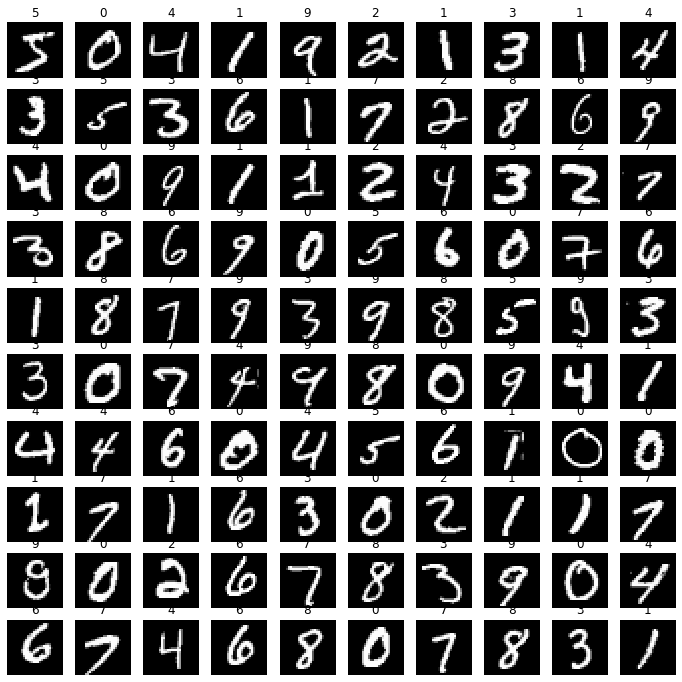

In [18]:
plt.figure(figsize=(12, 12))
for i in range(100):
    plt.subplot(10, 10, i+1)
    draw_image(Xtrain[i], Ttrain[i,0])

In [19]:
nnet = NeuralNetworkClassifier(784, [], 10)
nnet.train(Xtrain, Ttrain, 40)

SCG: Epoch 3 Error=0.95367
SCG: Epoch 7 Error=0.96867
SCG: Epoch 11 Error=0.97256
SCG: Epoch 15 Error=0.97373
SCG: Epoch 19 Error=0.97373
SCG: Epoch 23 Error=0.97373
SCG: Epoch 27 Error=0.97373
SCG: Epoch 31 Error=0.97379
SCG: Epoch 35 Error=0.97436
SCG: Epoch 39 Error=0.97558


NeuralNetwork(784, [], 10)

In [20]:
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest], [Ttrain, Tval, Ttest])]

[93.246, 92.76, 92.33]

In [21]:
nnet = NeuralNetworkClassifier(784, [20], 10)
nnet.train(Xtrain, Ttrain, 40)

SCG: Epoch 3 Error=0.94612
SCG: Epoch 7 Error=0.97072
SCG: Epoch 11 Error=0.97787
SCG: Epoch 15 Error=0.98187
SCG: Epoch 19 Error=0.98462
SCG: Epoch 23 Error=0.98674
SCG: Epoch 27 Error=0.98849
SCG: Epoch 31 Error=0.98991
SCG: Epoch 35 Error=0.99104
SCG: Epoch 39 Error=0.99197


NeuralNetwork(784, [20], 10)

In [22]:
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest], [Ttrain, Tval, Ttest])]

[97.976, 93.72, 93.35]

## Define `train_for_best_validation` and apply to MNIST data

Using the function `run` from Lecture Notes 11 as a guide, define a new function `train_for_best_validation` that accepts arguments
* `Xtrain, Ttrain`: matrices of shapes $N\times D$ and $N\times 1$ as input and target training data, where $N$ is number of training samples and $D$ is number of input components,
* `Xval, Tval`: matrices of shapes  $N\times D$ and $N\times 1$ of validation data ($N$ not same value as above)
* `n_epochs`: total number of epochs to train for,
* `n_epochs_per_train`: divide `n_epochs` by this value to get number of times the neural network `train` functin is called for this many epochs,
* `n_hiddens_list`: structure of hidden layers,
* `method`: optimizer method,
* `learning_rate`: used for optimizer methods 'adam' and 'sgd'.

It must return 
* `nnet`: resulting neural network with weights that produced the highest accuracy for the validation data set,
* `epoch`: epoch corresponding to best validation accuracy,
* `train_accuracy`: accuracy at that best epoch on training data,
* `val_accuracy`: accuracy at that best epoch on validation data.

This function should call your `percent_correct` function to calculate classification accuracies.

Apply it to the MNIST data as shown below.

In [6]:
def train_for_best_validation(Xtrain, Ttrain,  Xval, Tval,n_epochs, n_epochs_per_train, n_hiddens_list,method, learning_rate=None,plot=0):
    n_reps = n_epochs // n_epochs_per_train
    
    n_epochs_last_train = n_epochs - n_reps * n_epochs_per_train

    if n_epochs_last_train > 0:
        n_reps += 1
        
    n_inputs = Xtrain.shape[1]
    n_hiddens_list = n_hiddens_list
    n_outputs = len(np.unique(Ttrain).astype(int))
    
    nnet = NeuralNetworkClassifier(n_inputs, n_hiddens_list, n_outputs)
    best_all_weights = nnet.all_weights.copy()
    best_so_far = 0.0
    
     
    percent=[]
    for reps in range(n_reps):
  
        n_epoch = n_epochs_per_train 
        if n_epochs_last_train > 0 and reps == n_reps-1:
            n_epoch = n_epochs_last_train
            
        nnet.train(Xtrain, Ttrain, n_epoch, learning_rate, method=method, verbose=False)
        train_percent=percent_correct(nnet.use(Xtrain)[0], Ttrain)
        val_percent = percent_correct(nnet.use(Xval)[0], Tval)
        percent.append([nnet,(reps + 1) * n_epoch,train_percent,val_percent])
       
        if val_percent > best_so_far:
            best_so_far = val_percent
            best_all_weights[:] = nnet.all_weights
            
    percent = np.array(percent)
    
        

    best_val_index = np.argmax(percent[:, -1])
    nnet,best_val_epoch, best_train_accuracy, best_validation_accuracy = percent[best_val_index, :]
    print(f'Best validation accuracy is at epoch {best_val_epoch}', end='')
    print(f' with Accuracy Train of {best_train_accuracy:.2f} and Accuracy validation of {best_validation_accuracy:.2f}')
    
    if(plot==1):
        plt.plot(percent[:, 1], percent[:, 2], label='Train')
        plt.plot(percent[:, 1], percent[:, 3], label='val')
        plt.legend()
        ymin, ymax = plt.ylim()
        plt.plot([best_val_epoch, best_val_epoch], [ymin, ymax], 'r')
        plt.xlabel(f'Epochs')
        plt.ylabel('percent correct')
    
    # Put best weights into nnet
    nnet.all_weights[:] = best_all_weights
    
    if(learning_rate == None):
        learning_rate = 0 

    return nnet,best_val_epoch, best_train_accuracy, best_validation_accuracy

Best validation accuracy is at epoch 60 with Accuracy Train of 97.89 and Accuracy validation of 94.34


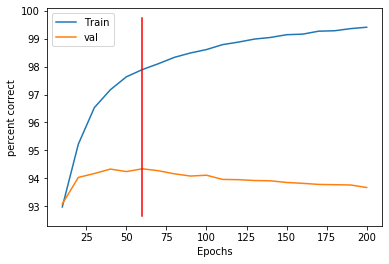

In [34]:
nnet,best_val_epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval,200, 10, [20], method='scg',plot=1) 

In [35]:
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest], [Ttrain, Tval, Ttest])]

[97.894, 94.34, 94.37]

Call `train_for_best_validation` a number of times to compare accuracies using the three different optimization methods, and a few different values of `n_epochs`, `n_epochs_per_train`, and `n_hiddens_list`, and `learning_rate` when using 'sgd' and 'adam'.  You do not have to find the very best values of these parameters.  For example, for `n_hiddens_list` at least use `[]` (a linear model) and a larger network, like `[100, 100]`.

Show the confusion matrix for the network that gave you the best validation accuracy.

Write at least 10 sentences about what you observe in the accuracy plots, the train, validation and test accuracies, and the confusion matrix.

In [36]:
import itertools

n_epochs = [100,300]
n_epochs_per_train = [10]
n_hiddens_list = [[],[50],[100,100]]
learning_rates = [0.01,0.001]

#-------------------------------------------------------for adam & sgd---------------------------------------------------------#
method = ['adam','sgd']
list = [n_epochs, n_epochs_per_train,n_hiddens_list,learning_rates,method]
combination = [p for p in itertools.product(*list)]
results=[]
print("Number of combination explored for adam and sgd",len(combination))
for i in range(len(combination)):
    epoch = combination[i][0]
    n_epoch_train = combination[i][1]
    n_hidden = combination[i][2]
    learning =combination[i][3]
    method = combination[i][4]
    nnet,best_val_epoch,train_accuracy, val_accuracy = train_for_best_validation(Xtrain,Ttrain,Xval,Tval,epoch,n_epoch_train,n_hidden,method,learning)
    results.append([nnet,method,best_val_epoch,learning,train_accuracy, val_accuracy])

#--------------------------------------------------------- for Scg-------------------------------------------------------------#
list2 =  [n_epochs, n_epochs_per_train,n_hiddens_list]
combination1 = [p for p in itertools.product(*list2)]
# print(combination1)
print("Number of combination explored for scg",len(combination1))
for i in range(len(combination1)):
    epoch = combination1[i][0]
    n_epoch_train = combination1[i][1]
    n_hidden = combination1[i][2]
    method = 'scg'
    nnet,best_val_epoch,train_accuracy, val_accuracy = train_for_best_validation(Xtrain,Ttrain,Xval,Tval,epoch,n_epoch_train,n_hidden,method)
    results.append([nnet,method,best_val_epoch,learning,train_accuracy, val_accuracy])

Number of combination explored for adam and sgd 24
Best validation accuracy is at epoch 10 with Accuracy Train of 86.95 and Accuracy validation of 88.16
Best validation accuracy is at epoch 100 with Accuracy Train of 50.23 and Accuracy validation of 51.92
Best validation accuracy is at epoch 100 with Accuracy Train of 91.79 and Accuracy validation of 91.83
Best validation accuracy is at epoch 100 with Accuracy Train of 11.55 and Accuracy validation of 11.90
Best validation accuracy is at epoch 90 with Accuracy Train of 98.94 and Accuracy validation of 95.22
Best validation accuracy is at epoch 100 with Accuracy Train of 37.27 and Accuracy validation of 37.63
Best validation accuracy is at epoch 100 with Accuracy Train of 94.61 and Accuracy validation of 93.73
Best validation accuracy is at epoch 100 with Accuracy Train of 12.92 and Accuracy validation of 12.75
Best validation accuracy is at epoch 60 with Accuracy Train of 99.25 and Accuracy validation of 96.25
Best validation accuracy 

In [37]:
df = pd.DataFrame(results,columns=['nnet', 'method','epoch','learning_rate', 'train_accuracy', 'val_accuracy'])
df
# df.sort_values(by=['val_accuracy'], ascending=False).head()

,nnet,method,epoch,learning_rate,train_accuracy,val_accuracy
0,"NeuralNetwork(784, [], 10)",adam,10,0.010,86.952,88.16
1,"NeuralNetwork(784, [], 10)",sgd,100,0.010,50.228,51.92
2,"NeuralNetwork(784, [], 10)",adam,100,0.001,91.790,91.83
3,"NeuralNetwork(784, [], 10)",sgd,100,0.001,11.546,11.90
4,"NeuralNetwork(784, [50], 10)",adam,90,0.010,98.938,95.22
5,"NeuralNetwork(784, [50], 10)",sgd,100,0.010,37.266,37.63
6,"NeuralNetwork(784, [50], 10)",adam,100,0.001,94.606,93.73
7,"NeuralNetwork(784, [50], 10)",sgd,100,0.001,12.922,12.75
8,"NeuralNetwork(784, [100, 100], 10)",adam,60,0.010,99.250,96.25
9,"NeuralNetwork(784, [100, 100], 10)",sgd,100,0.010,21.878,21.67


In [38]:
df.sort_values(by=['val_accuracy'], ascending=False).head(1)

,nnet,method,epoch,learning_rate,train_accuracy,val_accuracy
29,"NeuralNetwork(784, [100, 100], 10)",scg,80,0.001,100.0,97.15


In [39]:
Top_nnet=df.sort_values(by=['val_accuracy'], ascending=False).head(1)['nnet'].values[0]
Top_nnet

NeuralNetwork(784, [100, 100], 10)

In [40]:
top_precentage=[percent_correct(Top_nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest], [Ttrain, Tval, Ttest])]

In [41]:
print("precentage correct when training", top_precentage[0])
print("precentage correct when validating", top_precentage[1])
print("precentage correct when testing", top_precentage[2])

precentage correct when training 100.0
precentage correct when validating 97.15
precentage correct when testing 96.59


In [42]:
print("Confusion matrix of best neural net when Training")
confusion_matrix(Top_nnet.use(Xtrain)[0], Ttrain)

Confusion matrix of best neural net when Training
Percent Correct


,0,1,2,3,4,5,6,7,8,9
0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0


In [43]:
print("Confusion matrix of best neural net when validating")
confusion_matrix(Top_nnet.use(Xval)[0], Tval)

Confusion matrix of best neural net when validating
Percent Correct


,0,1,2,3,4,5,6,7,8,9
0,98.2,0.0,0.3,0.1,0.1,0.1,0.4,0.2,0.3,0.3
1,0.0,99.0,0.2,0.2,0.0,0.2,0.2,0.1,0.2,0.0
2,0.2,0.0,97.8,0.4,0.4,0.0,0.3,0.3,0.4,0.2
3,0.3,0.0,0.5,96.5,0.0,0.8,0.1,0.1,1.3,0.5
4,0.0,0.5,0.6,0.1,96.9,0.0,0.2,0.1,0.4,1.1
5,0.2,0.1,0.4,1.2,0.0,95.4,1.3,0.2,0.8,0.3
6,0.2,0.1,0.0,0.0,0.0,0.2,99.0,0.0,0.4,0.1
7,0.0,0.4,0.5,0.5,0.2,0.0,0.0,97.5,0.3,0.7
8,0.3,0.4,0.9,0.7,0.2,0.9,0.3,0.4,95.2,0.7
9,0.3,0.2,0.1,0.4,1.1,0.5,0.1,0.8,0.6,95.7


In [44]:
print("Confusion matrix of best neural net when testing")
confusion_matrix(Top_nnet.use(Xtest)[0], Ttest)

Confusion matrix of best neural net when testing
Percent Correct


,0,1,2,3,4,5,6,7,8,9
0,98.2,0.0,0.4,0.2,0.2,0.4,0.3,0.1,0.2,0.0
1,0.0,99.1,0.4,0.1,0.0,0.1,0.2,0.0,0.2,0.0
2,0.7,0.0,96.1,0.4,0.4,0.4,0.5,0.7,0.8,0.1
3,0.0,0.0,0.7,96.2,0.0,0.5,0.1,0.9,1.0,0.6
4,0.0,0.0,0.4,0.2,96.4,0.1,0.6,0.5,0.2,1.5
5,0.3,0.3,0.0,1.5,0.1,94.5,1.1,0.4,1.3,0.3
6,0.6,0.2,0.4,0.1,0.4,0.8,97.3,0.0,0.1,0.0
7,0.0,0.5,1.2,0.6,0.2,0.0,0.0,96.1,0.5,1.0
8,0.3,0.0,0.6,0.9,0.5,0.8,0.3,0.7,95.2,0.6
9,0.3,0.2,0.2,0.8,0.7,0.4,0.1,0.9,0.2,96.2


In [110]:
plotnet=df.sort_values(by=['val_accuracy'], ascending=False).head(5)
plotnet

,nnet,method,epoch,learning_rate,train_accuracy,val_accuracy
29,"NeuralNetwork(784, [100, 100], 10)",scg,80,0.001,100.000,97.15
26,"NeuralNetwork(784, [100, 100], 10)",scg,70,0.001,99.998,96.88
22,"NeuralNetwork(784, [100, 100], 10)",adam,240,0.001,100.000,96.54
20,"NeuralNetwork(784, [100, 100], 10)",adam,210,0.010,99.996,96.34
8,"NeuralNetwork(784, [100, 100], 10)",adam,60,0.010,99.250,96.25


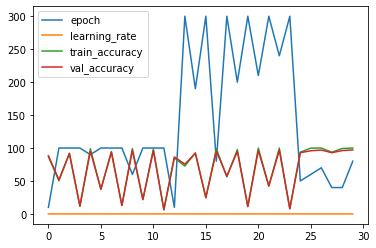

In [122]:

df.plot()
# plt.plot(df['method'].values,df['val_accuracy'].values)


## Observation

1. The scg optimizer performed better than the Sgd and Adam optimizers for the above dataset. In the last assignment i observed that SCG optimizer didnot perform well for the regression problem but here for a classification problem i can see that scg work better . 
2. The best configuration from the expierement was hiddenlist = [100,100], with a best trainingaccuracy of 100% and a validation accuracy of 97.15 percent The test accuracy for the model was 96.59 which was really close to the validation accuracy which means that the model is fit very well. 
3. We can also infer that unlike regression problem Adam performed better for the Image classification problem. The validation accuracy of adam was 96.54 which was very close to the top validation from scg. 
4. We can also see that the sgd was not even close to the top accuracy leaving us to believe that the given set of learning rates where not good enough for sgd to achieve the results. 
5. The least accuracy achieve when using Sgd was 6.39 while validating which was very low and the highest accuracy was 75.5 percent. 
6. When print the confusion matrix for the best validation accuracy model we can see that the least accurate prediction was at 95.4 percentage while validation and testing for the label 5. 
7. We can also observe that the model performed well when using higher values on the hidden layers which makes us believe that it is accurate to say that image classification models are more complex and need more hidden layers to perform the better. 
8. Adam performs well with both 0.001 and 0.01 learning rates which is really good. 
9. The models took pretty long time for running this was due to the number of inputs that was given to the model which was very high considering the number of images input was 50000 and number of input was 784 which corresponds to a 50000x784 inputs in total to be processed in each epoch for training. 
10. This training time problem can be over come with the help of GPU which will support parallel processing and creating partial sums instead of just using the Cpu. 

## ExtraCredit

In [12]:
xtrain= pickle.load( open( "dataset.pickle", "rb" ), encoding='latin1')

Xtrain1 =xtrain['x_train'].reshape(49000,-1)
Ttrain1 = xtrain['y_train'].reshape(-1, 1)
Xtrain1 = Xtrain1[:20000]
Ttrain1 = Ttrain1[:20000]
Xval1 = xtrain['x_validation'].reshape(1000,-1)
Tval1= xtrain['y_validation'].reshape(-1, 1)

Xtest1 = xtrain['x_test'].reshape(1000,-1)
Ttest1= xtrain['y_test'].reshape(-1, 1)

print(Xtrain1.shape, Ttrain1.shape,  Xval1.shape, Tval1.shape,  Xtest1.shape, Ttest1.shape)



(20000, 3072) (20000, 1) (1000, 3072) (1000, 1) (1000, 3072) (1000, 1)


In [13]:
nnet,best_val_epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain1, Ttrain1,  Xval1, Tval1,200, 10, [20], method='scg') 

Best validation accuracy is at epoch 60 with Accuracy Train of 47.52 and Accuracy validation of 41.30


In [14]:
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain1, Xval1, Xtest1], [Ttrain1, Tval1, Ttest1])]

[47.515, 41.3, 40.3]

In [23]:
confusion_matrix(nnet.use(Xval1)[0],Tval1)

Percent Correct


,0,1,2,3,4,5,6,7,8,9
0,43.7,4.6,3.4,5.7,3.4,1.1,2.3,9.2,21.8,4.6
1,1.7,53.8,5.9,4.2,2.5,0.8,2.5,8.4,4.2,16.0
2,10.1,2.5,35.4,13.9,8.9,7.6,5.1,7.6,8.9,0.0
3,8.0,3.6,11.6,21.4,4.5,10.7,17.9,6.2,8.0,8.0
4,6.4,7.7,17.9,1.3,43.6,3.8,5.1,9.0,2.6,2.6
5,1.0,4.1,13.3,16.3,5.1,25.5,10.2,14.3,7.1,3.1
6,1.0,2.0,6.9,10.8,9.8,6.9,51.0,5.9,2.0,3.9
7,3.7,2.8,10.3,7.5,7.5,8.4,5.6,44.9,2.8,6.5
8,5.3,1.8,0.0,1.8,1.8,1.8,1.8,0.0,80.5,5.3
9,7.6,13.3,6.7,4.8,1.0,2.9,2.9,3.8,10.5,46.7


In [16]:
nnet,best_val_epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain1, Ttrain1,  Xval1, Tval1,100, 10, [], method='scg') 

Best validation accuracy is at epoch 60 with Accuracy Train of 46.11 and Accuracy validation of 39.90


In [17]:
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain1, Xval1, Xtest1], [Ttrain1, Tval1, Ttest1])]

[46.11, 39.9, 39.3]

In [19]:
nnet,best_val_epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain1, Ttrain1,  Xval1, Tval1,100, 10, [100, 100], method='scg') 

Best validation accuracy is at epoch 90 with Accuracy Train of 60.81 and Accuracy validation of 46.20


In [20]:
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain1, Xval1, Xtest1], [Ttrain1, Tval1, Ttest1])]

[60.815, 46.2, 42.4]

In [22]:
nnet,best_val_epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain1, Ttrain1,  Xval1, Tval1,300, 10, [100, 100], method='scg') 

Best validation accuracy is at epoch 70 with Accuracy Train of 56.71 and Accuracy validation of 45.30


In [26]:
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain1, Xval1, Xtest1], [Ttrain1, Tval1, Ttest1])]

[56.71, 45.3, 43.5]

In [27]:
confusion_matrix(nnet.use(Xval1)[0],Tval1)

Percent Correct


,0,1,2,3,4,5,6,7,8,9
0,43.7,4.6,3.4,5.7,3.4,1.1,2.3,9.2,21.8,4.6
1,1.7,53.8,5.9,4.2,2.5,0.8,2.5,8.4,4.2,16.0
2,10.1,2.5,35.4,13.9,8.9,7.6,5.1,7.6,8.9,0.0
3,8.0,3.6,11.6,21.4,4.5,10.7,17.9,6.2,8.0,8.0
4,6.4,7.7,17.9,1.3,43.6,3.8,5.1,9.0,2.6,2.6
5,1.0,4.1,13.3,16.3,5.1,25.5,10.2,14.3,7.1,3.1
6,1.0,2.0,6.9,10.8,9.8,6.9,51.0,5.9,2.0,3.9
7,3.7,2.8,10.3,7.5,7.5,8.4,5.6,44.9,2.8,6.5
8,5.3,1.8,0.0,1.8,1.8,1.8,1.8,0.0,80.5,5.3
9,7.6,13.3,6.7,4.8,1.0,2.9,2.9,3.8,10.5,46.7


In [ ]:
import itertools

n_epochs = [100,300]
n_epochs_per_train = [10]
n_hiddens_list = [[],[50],[100,100]]
learning_rates = [0.01,0.001]

#-------------------------------------------------------for adam & sgd---------------------------------------------------------#
method = ['adam','sgd']
list = [n_epochs, n_epochs_per_train,n_hiddens_list,learning_rates,method]
combination = [p for p in itertools.product(*list)]
results1=[]
print("Number of combination explored for adam and sgd",len(combination))
for i in range(len(combination)):
    epoch = combination[i][0]
    n_epoch_train = combination[i][1]
    n_hidden = combination[i][2]
    learning =combination[i][3]
    method = combination[i][4]
    nnet,best_val_epoch,train_accuracy, val_accuracy = train_for_best_validation(Xtrain1,Ttrain1,Xval1,Tval1,epoch,n_epoch_train,n_hidden,method,learning)
    results1.append([nnet,method,best_val_epoch,learning,train_accuracy, val_accuracy])


Number of combination explored for adam and sgd 24
Best validation accuracy is at epoch 10 with Accuracy Train of 27.44 and Accuracy validation of 28.20
Best validation accuracy is at epoch 100 with Accuracy Train of 29.20 and Accuracy validation of 30.10
Best validation accuracy is at epoch 100 with Accuracy Train of 40.54 and Accuracy validation of 40.20
Best validation accuracy is at epoch 100 with Accuracy Train of 16.96 and Accuracy validation of 16.90
Best validation accuracy is at epoch 70 with Accuracy Train of 46.33 and Accuracy validation of 43.40
Best validation accuracy is at epoch 100 with Accuracy Train of 22.86 and Accuracy validation of 23.00
Best validation accuracy is at epoch 100 with Accuracy Train of 46.53 and Accuracy validation of 45.60
Best validation accuracy is at epoch 80 with Accuracy Train of 14.31 and Accuracy validation of 14.10
Best validation accuracy is at epoch 70 with Accuracy Train of 46.56 and Accuracy validation of 45.10
Best validation accuracy i

## Observation 


1. The dataset i used was cifar10 dataset which has a 3 channel image. i wanted to try the cifar10 just to check performance of the network on a 3 dimensional data. 
2. I used a test split of 49000 , validation split of 1000 and test split of 1000. 
3. the dataset is available [here](https://drive.google.com/file/d/1z9Kv-4ZLY0nVQlNPkX7aTAxzfFqW68XT/view?usp=sharing) 
4. We can see that Adam performed really well than the scg and sgd optimizer in this case too. 
5. The best accuracy was for 300 epochs with a training accuracy of 49.83   and validation accuracy of 46.30
6. Unlike the Earlier dataset (mnist) the model gave lesser accuracy on this dataset this can be due to the complexity of the dataset which has 3 channels. 

**I was not able to run the expirement fully since it was taking very long. I was running it for a day and still was having trouble finishing it. please consider this for extra credit.** 

# Grading

Download [A4grader.tar](https://www.cs.colostate.edu/~anderson/cs545/notebooks/A4grader.tar), extract `A4grader.py` before running the following cell.


======================= Code Execution =======================

Extracting python code from notebook named 'Balasubramaniam-A4.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

## Testing constructor ####################################################################

    # Linear network
    nnet = NeuralNetworkClassifier(2, [], 5)
    # Is isinstance(nnet, NeuralNetwork) True?


--- 5/5 points. NeuralNetworkClassifier is correctly of type NeuralNetwork

## Testing constructor ####################################################################

    # Linear network
    nnet = NeuralNetworkClassifier(2, [], 5)
    W_shapes = [W.shape for W in nnet.Ws]


--- 5/5 points. W_shapes is correct value of [(3, 5)]

## Testing constructor ####################################################################

    G_shapes = [G.shape for G in nnet.Gs]


--- 5/5 points. G_shapes is correct value of [(3, 5)]

## Testing train 

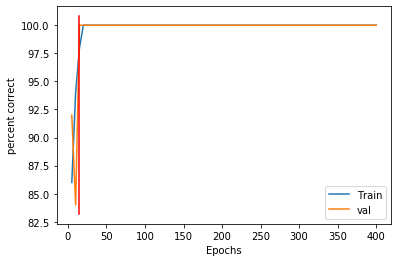

In [115]:
 %run -i A4grader.py

# Extra Credit

Repeat the above experiments with a different data set.  Randonly partition your data into training, validaton and test parts if not already provided.  Write in markdown cells descriptions of the data and your results.